In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from arch.unitroot import ADF, PhillipsPerron
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings('ignore')

In [40]:
household_power_consumption = pd.read_csv("household_power_consumption.txt", sep=';',
                                                parse_dates={'DateTime' : ['Date', 'Time']}, 
                                                index_col=["DateTime"],
                                                dayfirst=True,
                                                low_memory=False,
                                                na_values=['nan','?'])


In [41]:
household_power_consumption = household_power_consumption[household_power_consumption.index > "2006-12-26"]
household_power_consumption = household_power_consumption[household_power_consumption.index < "2009-12-31"]
household_power_consumption = household_power_consumption.fillna(method="ffill")

In [43]:
household_power_consumption.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1585439 entries, 2006-12-26 00:01:00 to 2009-12-30 23:59:00
Data columns (total 7 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Global_active_power    1585439 non-null  float64
 1   Global_reactive_power  1585439 non-null  float64
 2   Voltage                1585439 non-null  float64
 3   Global_intensity       1585439 non-null  float64
 4   Sub_metering_1         1585439 non-null  float64
 5   Sub_metering_2         1585439 non-null  float64
 6   Sub_metering_3         1585439 non-null  float64
dtypes: float64(7)
memory usage: 96.8 MB


<Axes: xlabel='DateTime'>

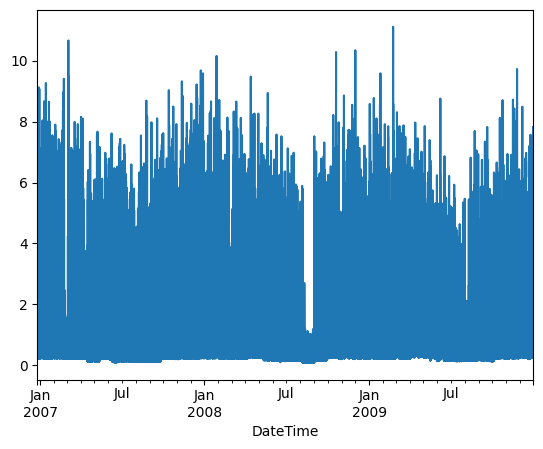

In [47]:
household_power_consumption["Global_active_power"].plot()

## Creating daily weekly monthly and quarterly Dataframes


In [6]:
household_power_consumption = household_power_consumption["Global_active_power"]
household_power_consumption = household_power_consumption.dropna()
daily = household_power_consumption.resample("D").mean()
# daily.to_csv("daily.csv")
weekly = household_power_consumption.resample("W").mean()
# weekly.to_csv("weekly.csv")
monthly = household_power_consumption.resample("M").mean()
# monthly.to_csv("monthly.csv")
quarterly = household_power_consumption.resample("3M").mean()
# quarterly.to_csv("quarterly.csv")

[]

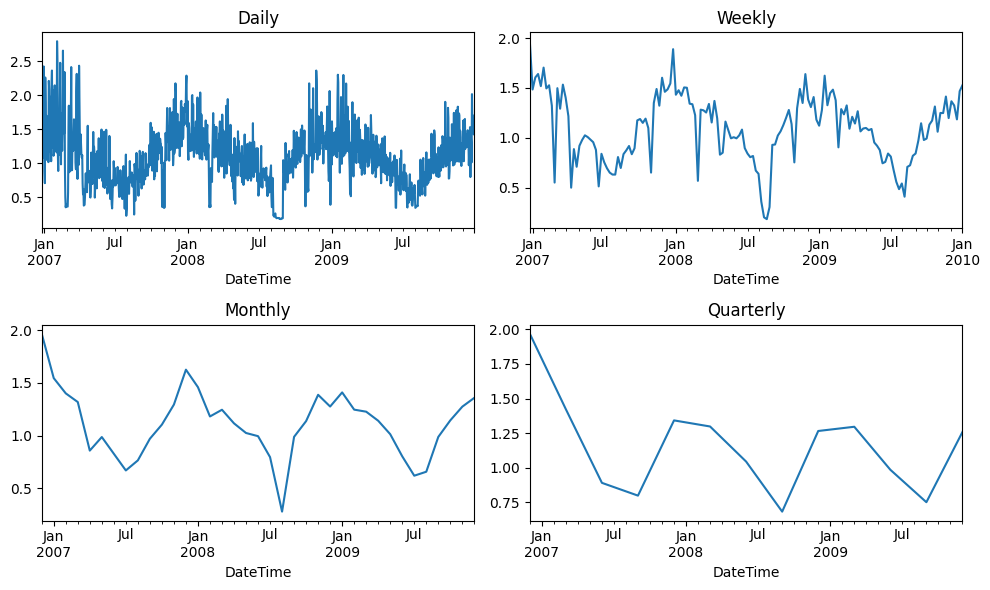

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
daily.plot(y="Global_active_power", ax=axes[0,0], title="Daily")
weekly.plot(y="Global_active_power", ax=axes[0,1], title="Weekly")
monthly.plot(y="Global_active_power", ax=axes[1,0], title="Monthly")
quarterly.plot(y="Global_active_power", ax=axes[1,1], title="Quarterly")
plt.tight_layout()
plt.savefig("full_series.png")
plt.plot()

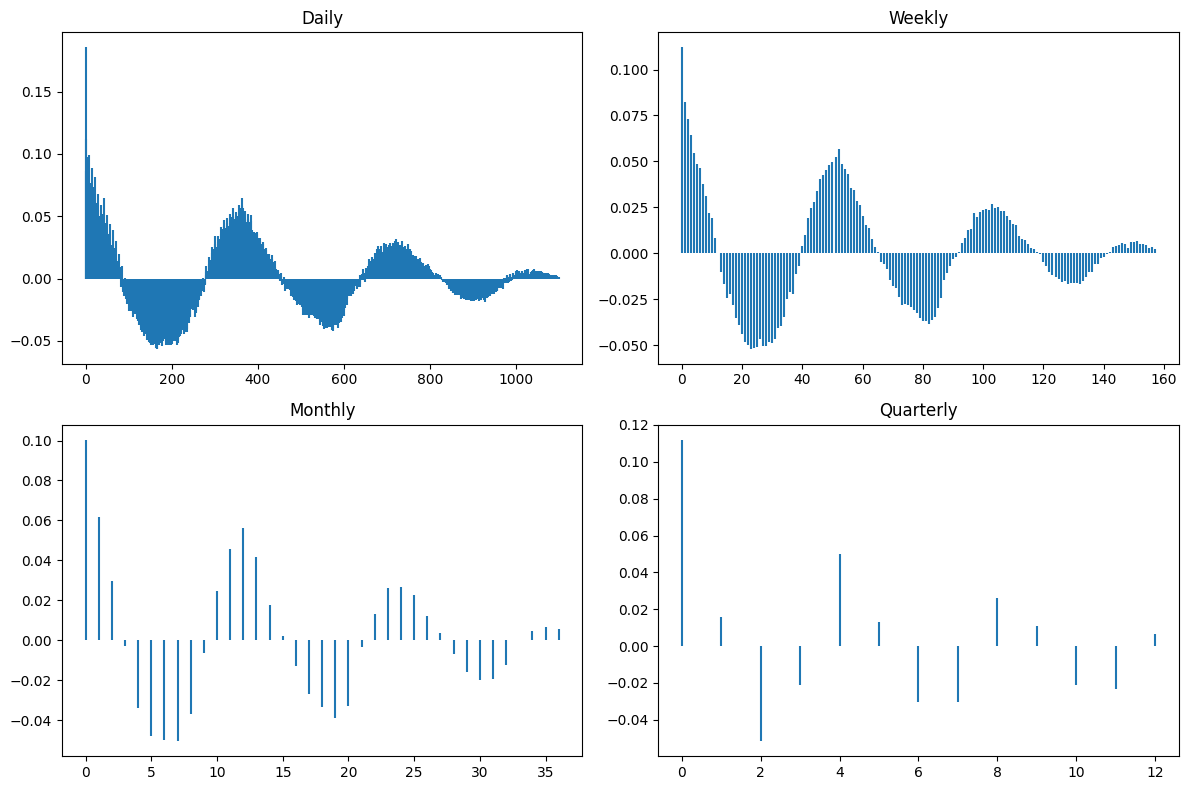

<Figure size 640x480 with 0 Axes>

In [8]:
def autocovariance(series, lag):
    len_series = len(series)
    mean = np.mean(series)

    covarianc_acc=0
    for index in range(lag, len_series):
        summand = (series[index]-mean) * (series[index-lag]-mean)
        covarianc_acc+=summand

    autocovariance =  covarianc_acc / len_series
    return autocovariance


def plot_acvf_subplots(timeseries_list, titles_list):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.flatten()

    for i, timeseries in enumerate(timeseries_list):
        ax = axs[i]
        acvf = [autocovariance(timeseries, lag) for lag in range(len(timeseries))]
        ax.vlines([i for i in range(len(acvf))], ymax=acvf, ymin=0)
        ax.set_title(titles_list[i])

    plt.tight_layout()
    plt.show()

plot_acvf_subplots([daily, weekly, monthly, quarterly], ["Daily", "Weekly", "Monthly", "Quarterly"])

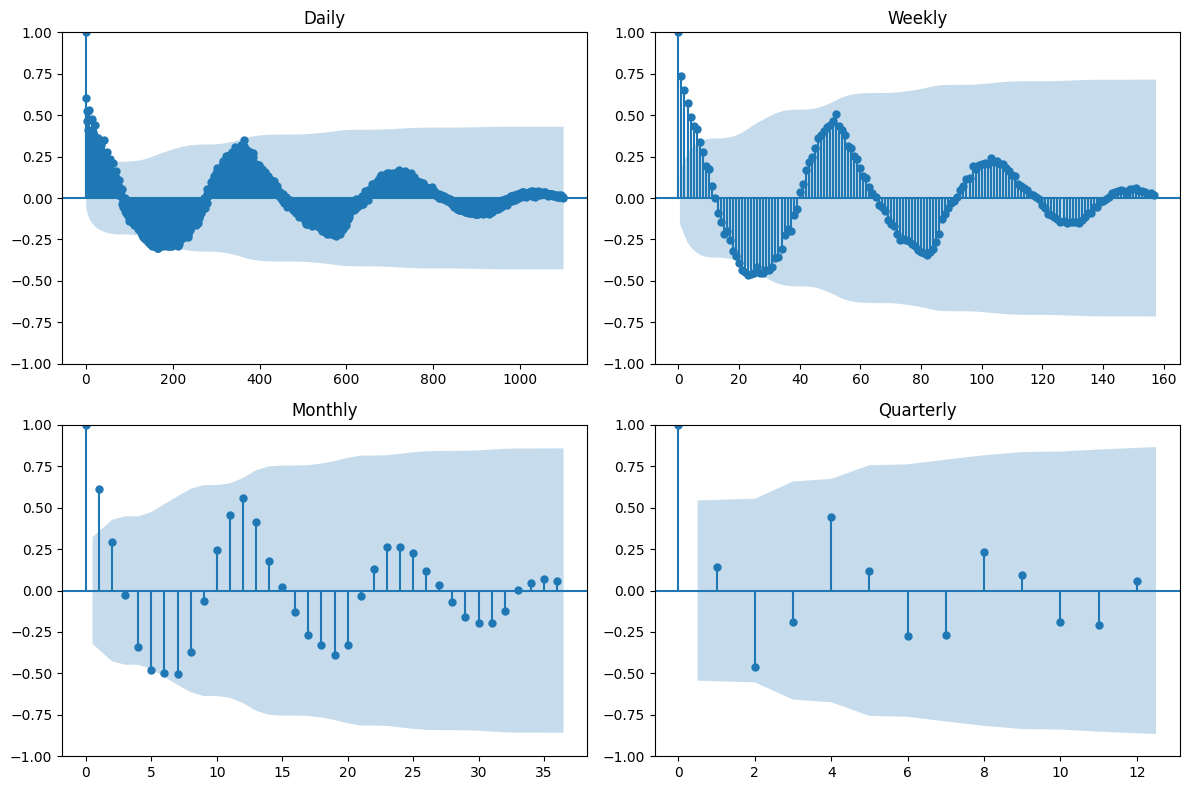

In [9]:
def plot_acf_subplots(timeseries_list, titles_list):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.flatten()

    for i, timeseries in enumerate(timeseries_list):
        ax = axs[i]
        plot_acf(timeseries, ax=ax, title=titles_list[i], lags=len(timeseries)-1)

    plt.tight_layout()

plot_acf_subplots([daily, weekly, monthly, quarterly], ["Daily", "Weekly", "Monthly", "Quarterly"])

## Decompose Trend and Seasonality  

In [10]:
def decompose(time_period, period):
    decomposition = sm.tsa.seasonal_decompose(time_period, model='additive', period=period)
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 6))
    axes[0].plot(decomposition.trend)
    axes[0].set_title("Trend")
    axes[1].plot(decomposition.seasonal)
    axes[1].set_title("Seasonality")
    axes[2].plot(decomposition.resid)
    axes[2].set_title("Residual")
    plt.tight_layout()
    plt.savefig(f"{period}.png")
    plt.plot()
    print(ADF(decomposition.resid.dropna()))
    #print(PhillipsPerron(decomposition.resid.dropna()))
    return decomposition.resid.dropna()

   Augmented Dickey-Fuller Results   
Test Statistic                 -5.270
P-value                         0.000
Lags                               18
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


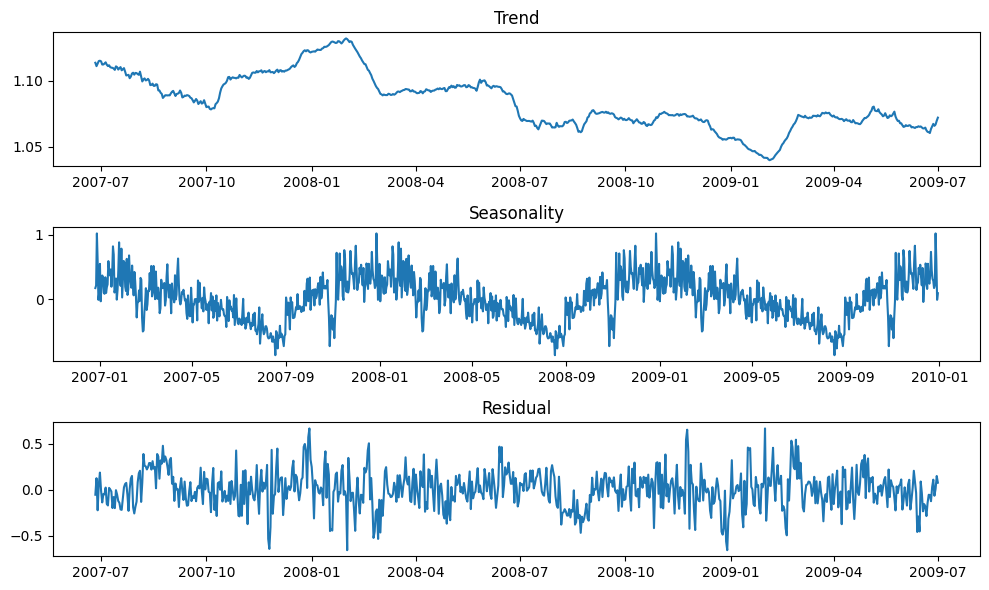

In [11]:
daily_resid = decompose(daily, 365)

In [12]:
len(daily_resid)

737

   Augmented Dickey-Fuller Results   
Test Statistic                 -5.044
P-value                         0.000
Lags                               11
-------------------------------------

Trend: Constant
Critical Values: -3.50 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


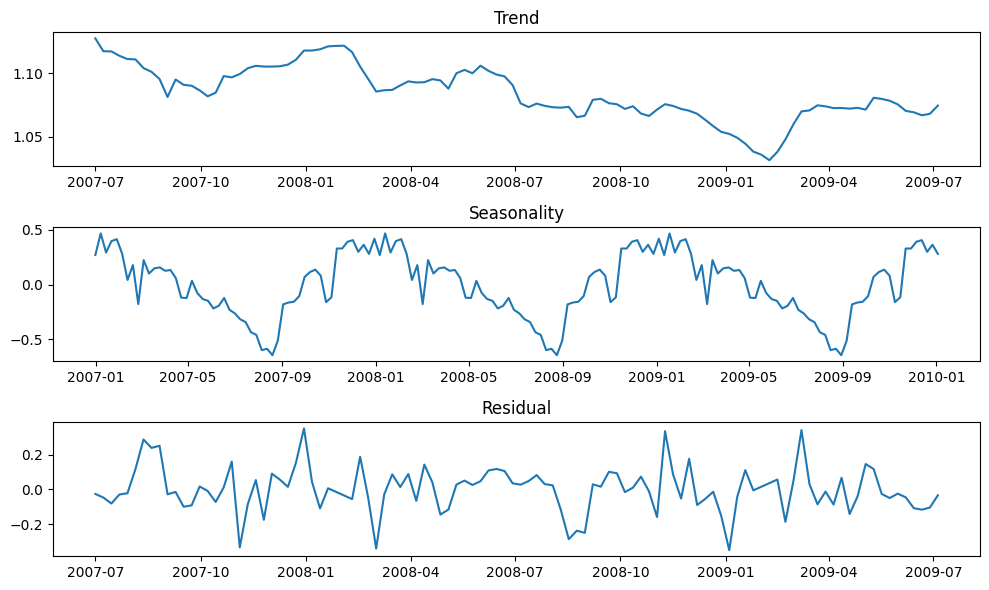

In [13]:
weekly_resid = decompose(weekly, 53)

   Augmented Dickey-Fuller Results   
Test Statistic                 -5.572
P-value                         0.000
Lags                                2
-------------------------------------

Trend: Constant
Critical Values: -3.77 (1%), -3.01 (5%), -2.64 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


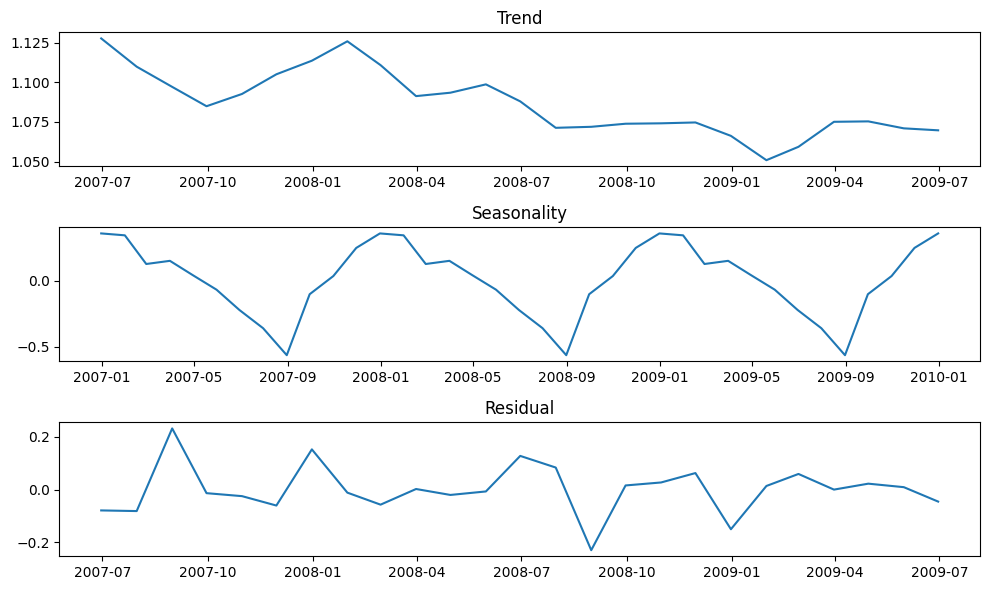

In [14]:
monthly_resid = decompose(monthly, 12)

   Augmented Dickey-Fuller Results   
Test Statistic                 -5.393
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -4.67 (1%), -3.37 (5%), -2.80 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


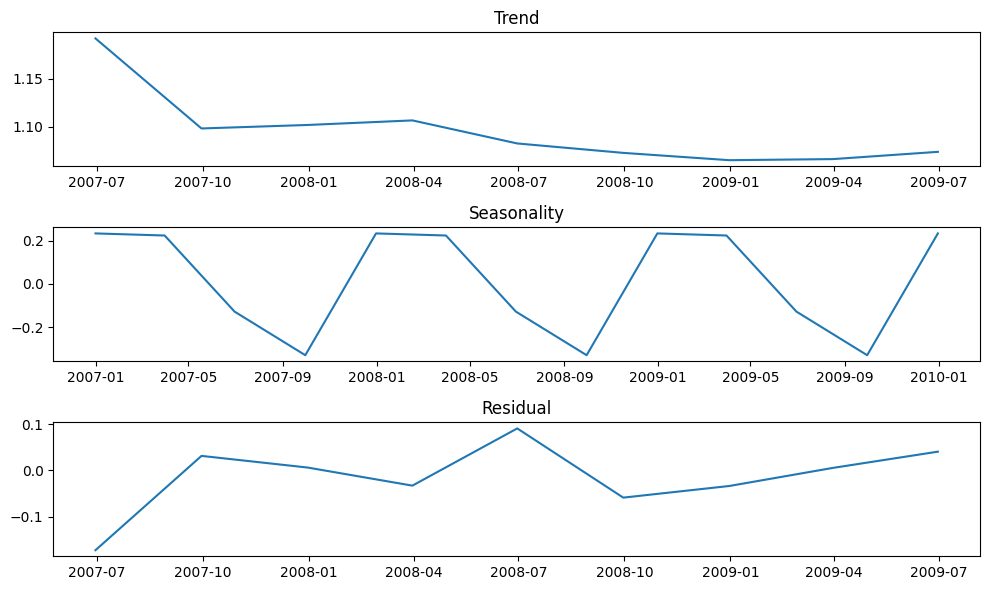

In [15]:
quarterly_resid = decompose(quarterly, 4)

[]

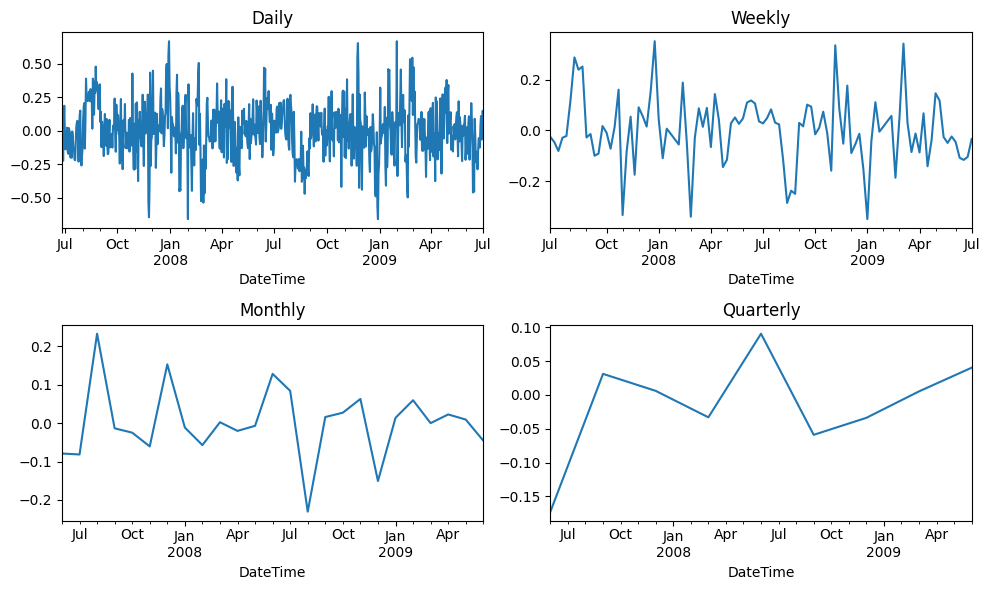

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
daily_resid.plot(y="Global_active_power", ax=axes[0,0], title="Daily")
weekly_resid.plot(y="Global_active_power", ax=axes[0,1], title="Weekly")
monthly_resid.plot(y="Global_active_power", ax=axes[1,0], title="Monthly")
quarterly_resid.plot(y="Global_active_power", ax=axes[1,1], title="Quarterly")
plt.tight_layout()
plt.savefig("resids.png")
plt.plot()

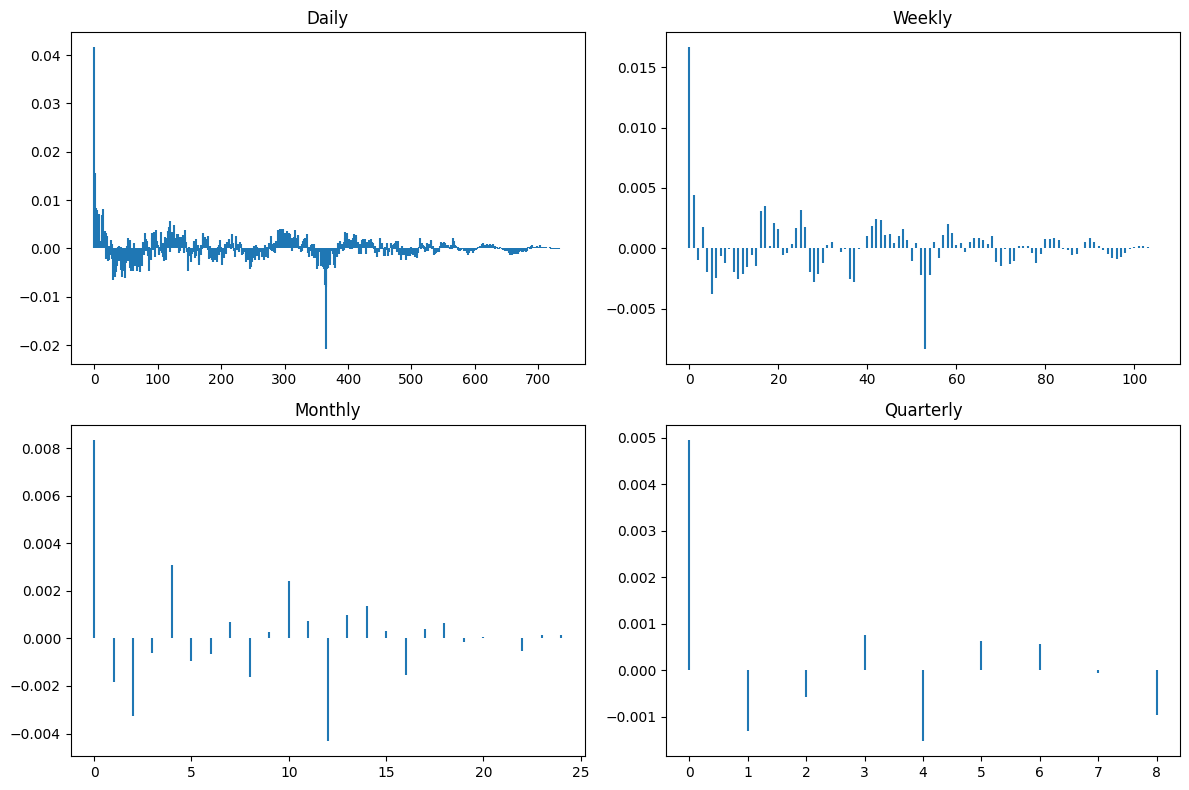

In [16]:
plot_acvf_subplots([daily_resid, weekly_resid, monthly_resid, quarterly_resid], ["Daily", "Weekly", "Monthly", "Quarterly"])

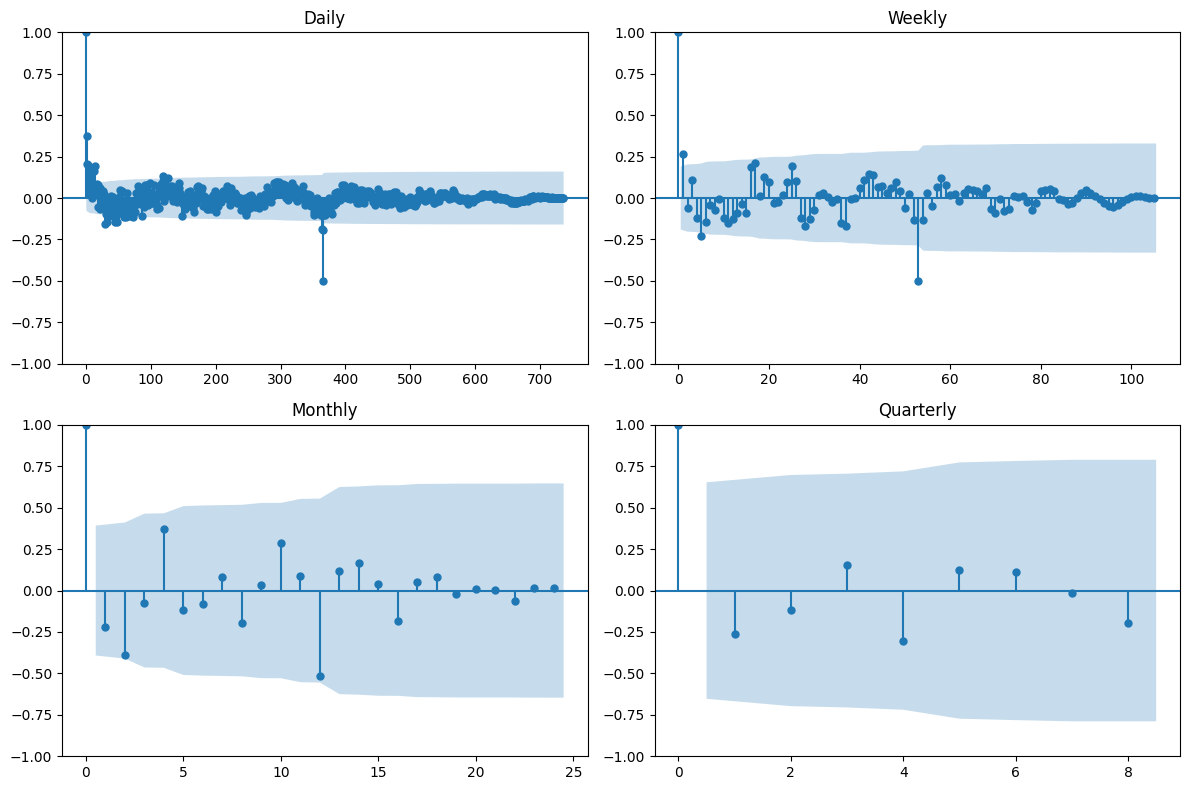

In [17]:
plot_acf_subplots([daily_resid, weekly_resid, monthly_resid, quarterly_resid], ["Daily", "Weekly", "Monthly", "Quarterly"])

In [18]:
def test_arima(timeseries):
    order_values = [(p, d, q) for p in range(4) for d in range(2) for q in range(4)]
    best_aicc = float('inf')
    best_order = None

    for p in range(4):
        for d in range(2):
            for q in range(4):
                model = ARIMA(timeseries, order=(p, d, q))
                results = model.fit()
                aicc = results.aic
                if aicc < best_aicc:
                    best_aicc = aicc
                    best_order = (p, d, q)
        
    return best_order, best_aicc


In [19]:
print("Best daily ARIMA parameters & AICC:")
test_arima(daily_resid)

Best daily ARIMA parameters & AICC:


((3, 0, 3), -384.19045524826475)

In [20]:
print("Best weekly ARIMA parameters & AICC:")
test_arima(weekly_resid)

Best weekly ARIMA parameters & AICC:


((3, 0, 3), -145.98420460768008)

In [21]:
print("Best monthly ARIMA parameters & AICC:")
test_arima(monthly_resid)

Best monthly ARIMA parameters & AICC:


((3, 0, 0), -51.47667822680599)

In [22]:
print("Best quarterly ARIMA parameters & AICC:")
test_arima(quarterly_resid)

Best quarterly ARIMA parameters & AICC:


((0, 0, 2), -20.68658554672848)

# Quality Model Check 

const     0.010879
ar.L1     1.962484
ar.L2    -1.396977
ar.L3     0.270050
ma.L1    -1.633892
ma.L2     0.924439
sigma2    0.034626
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  737
Model:                 ARIMA(3, 0, 2)   Log Likelihood                 198.415
Date:                Wed, 24 May 2023   AIC                           -382.830
Time:                        20:28:21   BIC                           -350.612
Sample:                    06-26-2007   HQIC                          -370.406
                         - 07-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0109      0.012      0.891      0.373      -0

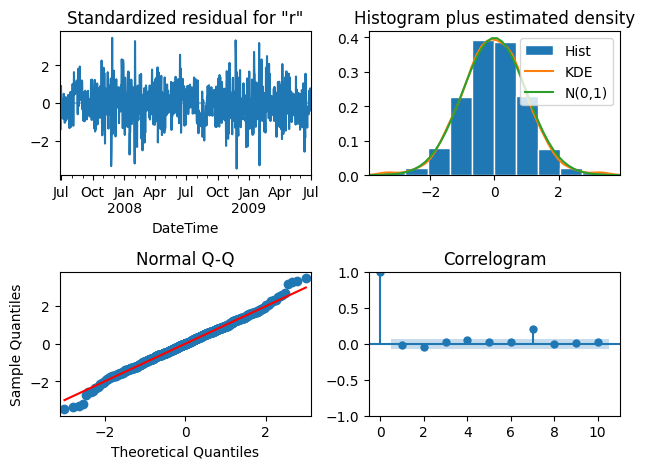

In [23]:
from scipy.stats import shapiro
model = ARIMA(daily_resid, order=(3, 0, 2)).fit()
model.plot_diagnostics()
plt.tight_layout()
plt.savefig("diagnostics_daily.png")
print(model.params)
print(model.summary())
print(shapiro(model.standardized_forecasts_error))


const     0.001402
ar.L1     0.398823
ar.L2     0.396804
ma.L1    -0.101958
ma.L2    -0.893874
sigma2    0.012944
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  106
Model:                 ARIMA(2, 0, 2)   Log Likelihood                  78.809
Date:                Wed, 24 May 2023   AIC                           -145.618
Time:                        20:28:22   BIC                           -129.637
Sample:                    07-01-2007   HQIC                          -139.141
                         - 07-05-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.006      0.234      0.815      -0.010       0.013
ar

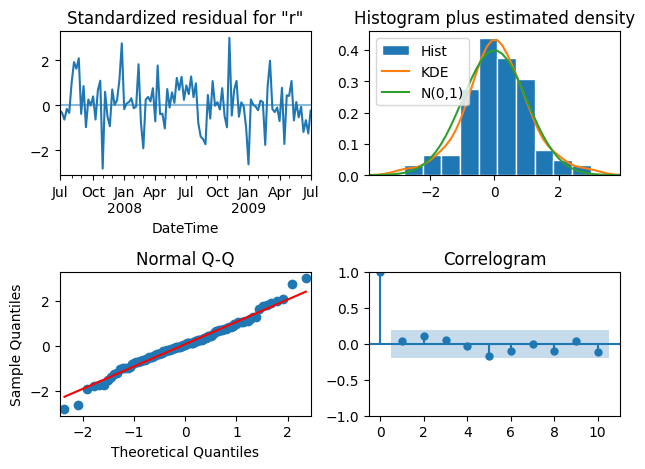

In [24]:
model2 = ARIMA(weekly_resid, order=(2, 0, 2)).fit()
model2.plot_diagnostics()
plt.tight_layout()
plt.savefig("diagnostics_weekly.png")
print(model2.params)
print(model2.summary())
print(shapiro(model2.standardized_forecasts_error))

const     0.002786
ma.L1    -0.761086
sigma2    0.006030
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                   25
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  27.979
Date:                Wed, 24 May 2023   AIC                            -49.959
Time:                        20:28:22   BIC                            -46.302
Sample:                    06-30-2007   HQIC                           -48.945
                         - 06-30-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.005      0.509      0.611      -0.008       0.014
ma.L1         -0.7611      0.179     -4.247      0.000     

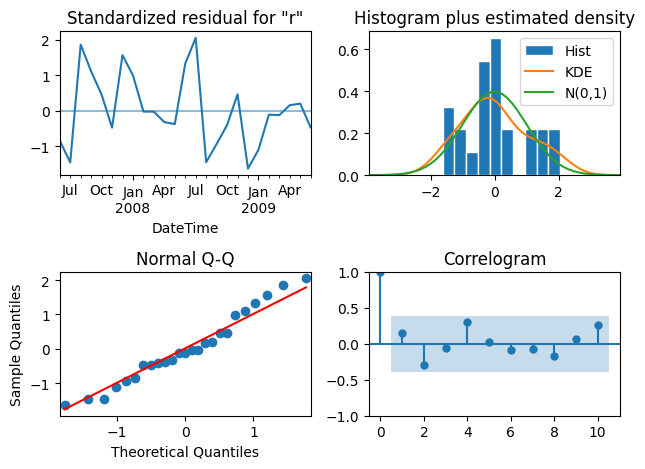

In [25]:
model3 = ARIMA(monthly_resid, order=(0, 0, 1)).fit()
model3.plot_diagnostics()
plt.tight_layout()
plt.savefig("diagnostics_monthly.png")
print(model3.params)
print(model3.summary())
print(shapiro(model3.standardized_forecasts_error))

In [26]:
model4 = ARIMA(quarterly_resid, order=(0, 0, 1)).fit()
print(model4.params)
print(model4.summary())
print(shapiro(model4.standardized_forecasts_error))

const    -0.006819
ma.L1    -0.999821
sigma2    0.002459
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                    9
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  13.115
Date:                Wed, 24 May 2023   AIC                            -20.230
Time:                        20:28:22   BIC                            -19.638
Sample:                    06-30-2007   HQIC                           -21.507
                         - 06-30-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0068      0.010     -0.664      0.507      -0.027       0.013
ma.L1         -0.9998   1213.601     -0.001      0.999   -2

## Forecast

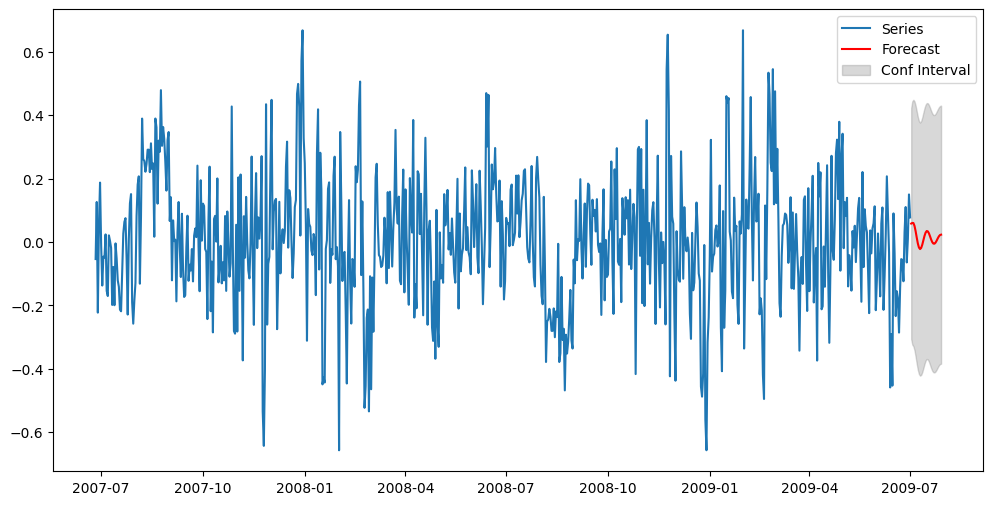

In [27]:
forecast = model.get_forecast(steps=28) 
forecast_values = forecast.predicted_mean
confidence_interval = forecast.conf_int()  
plt.figure(figsize=(12, 6))
plt.plot(daily_resid, label='Series')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.fill_between(confidence_interval.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='gray', alpha=0.3, label='Conf Interval')
plt.legend()
plt.show()

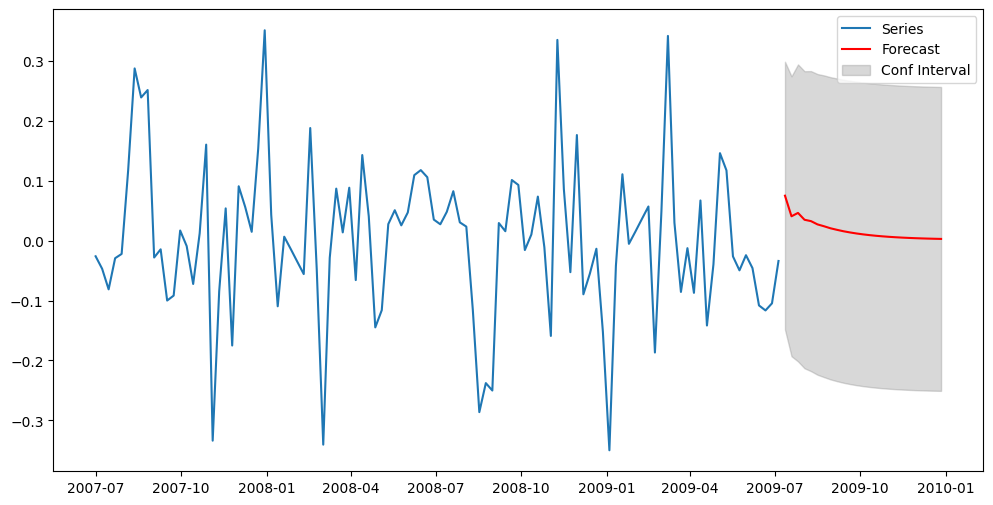

In [28]:
forecast = model2.get_forecast(steps=25) 
forecast_values = forecast.predicted_mean
confidence_interval = forecast.conf_int()  
plt.figure(figsize=(12, 6))
plt.plot(weekly_resid, label='Series')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.fill_between(confidence_interval.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='gray', alpha=0.3, label='Conf Interval')
plt.legend()
plt.show()

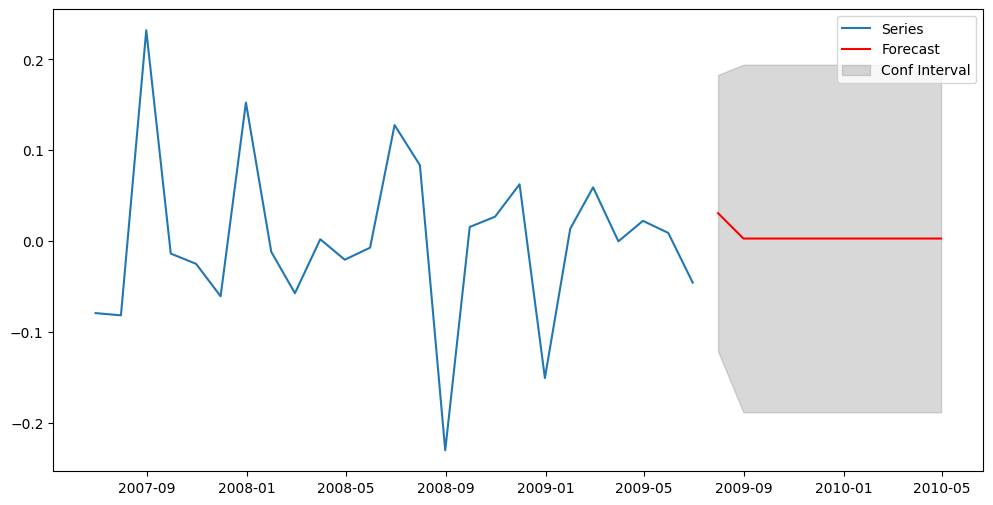

In [29]:
forecast = model3.get_forecast(steps=10) 
forecast_values = forecast.predicted_mean
confidence_interval = forecast.conf_int()  
plt.figure(figsize=(12, 6))
plt.plot(monthly_resid, label='Series')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.fill_between(confidence_interval.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='gray', alpha=0.3, label='Conf Interval')
plt.legend()
plt.show()

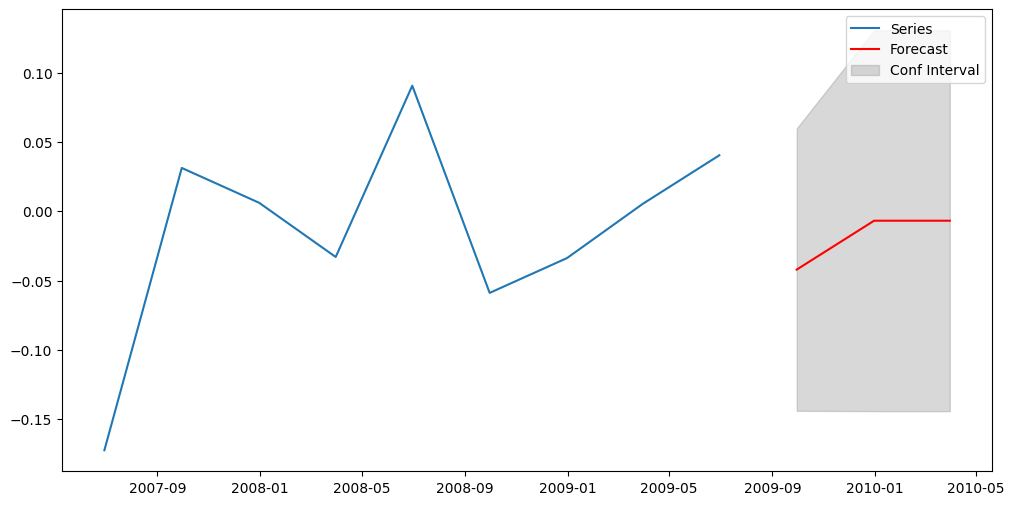

In [30]:
forecast = model4.get_forecast(steps=3) 
forecast_values = forecast.predicted_mean
confidence_interval = forecast.conf_int()  
plt.figure(figsize=(12, 6))
plt.plot(quarterly_resid, label='Series')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.fill_between(confidence_interval.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='gray', alpha=0.3, label='Conf Interval')
plt.legend()
plt.show()

# ACF

In [31]:
def acf_plot(timeseries, title):
    fig, ax = plt.subplots(figsize=(10, 5))
    plot_acf(timeseries, ax=ax)
    ax.set_xlabel('Lag')
    ax.set_ylabel('Autocorrelation')
    ax.set_title(title)
    plt.show()
    count=len(timeseries)
    print('the number of values is:',count)

In [32]:
def autocovariance(series, lag):
    len_series = len(series)
    mean = np.mean(series)

    covarianc_acc=0
    for index in range(lag, len_series):
        summand = (series[index]-mean) * (series[index-lag]-mean)
        covarianc_acc+=summand

    autocovariance =  covarianc_acc / len_series
    return autocovariance


def plot_acvf(timeseries, title):
    acvf = [autocovariance(timeseries, lag) for lag in range(len(timeseries))]
    plt.vlines([i for i in range(len(acvf))],ymax=acvf,ymin=0)
    plt.title(title)
    

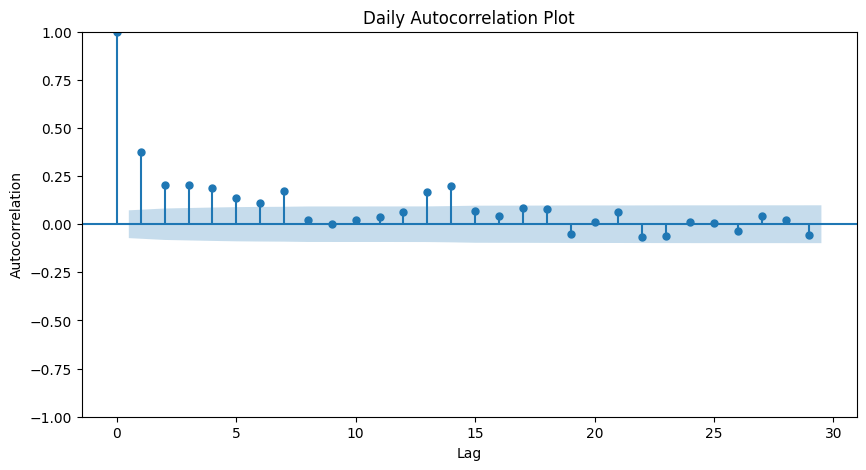

the number of values is: 737


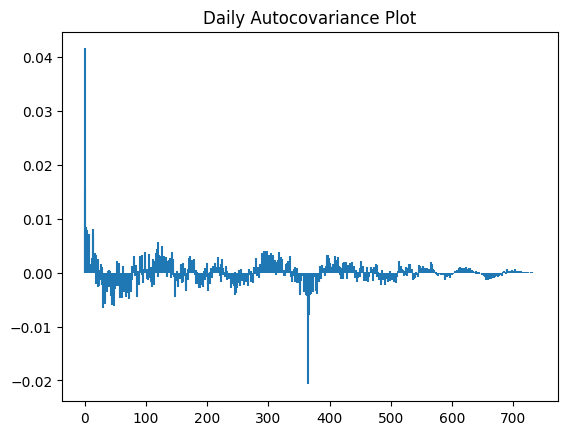

In [33]:
acf_plot(daily_resid, "Daily Autocorrelation Plot")
plot_acvf(daily_resid, "Daily Autocovariance Plot")

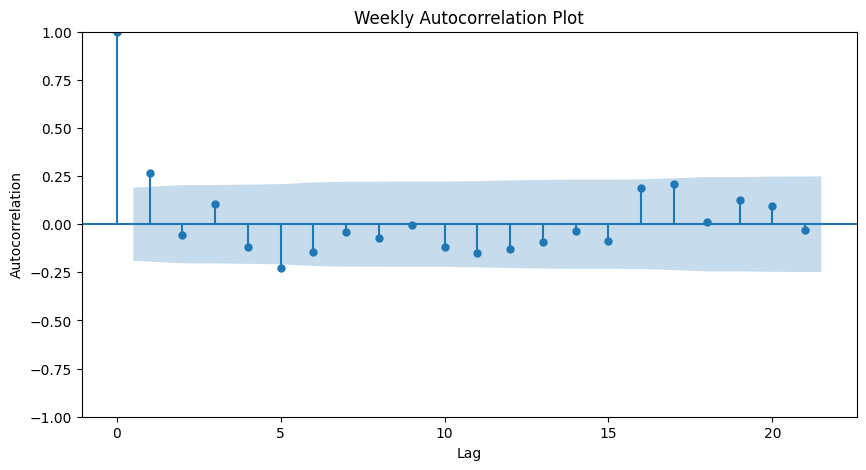

the number of values is: 106


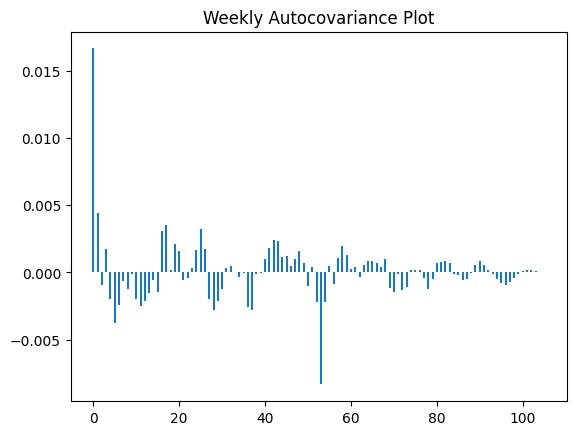

In [34]:
acf_plot(weekly_resid, "Weekly Autocorrelation Plot")
plot_acvf(weekly_resid, "Weekly Autocovariance Plot")

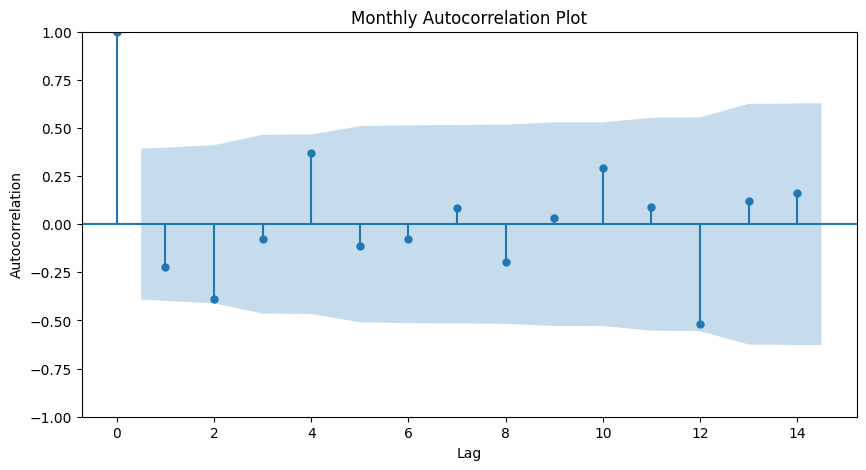

the number of values is: 25


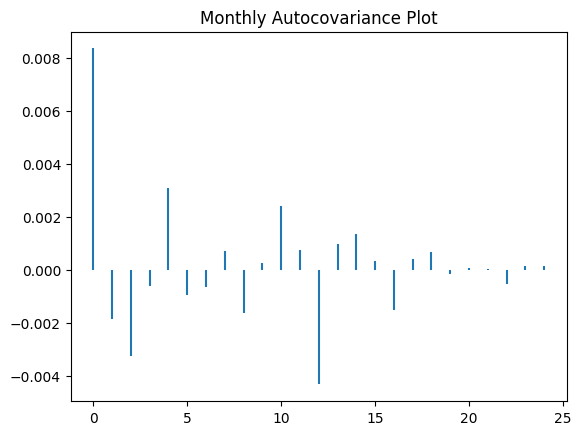

In [35]:
acf_plot(monthly_resid, "Monthly Autocorrelation Plot")
plot_acvf(monthly_resid, "Monthly Autocovariance Plot")

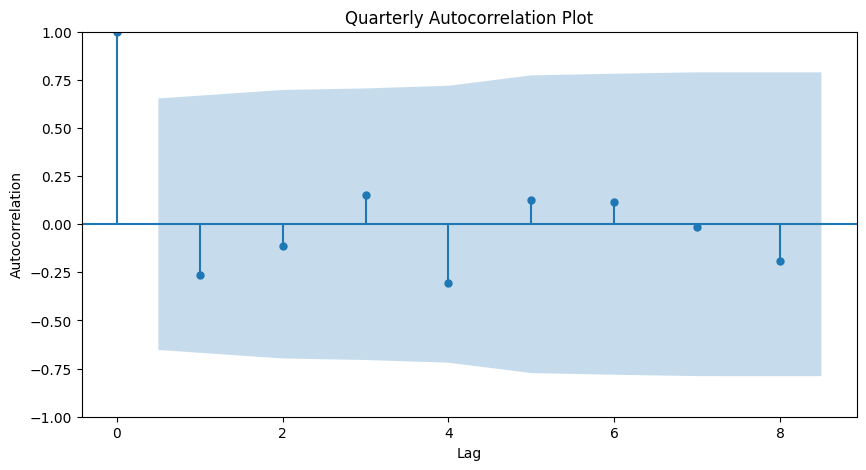

the number of values is: 9


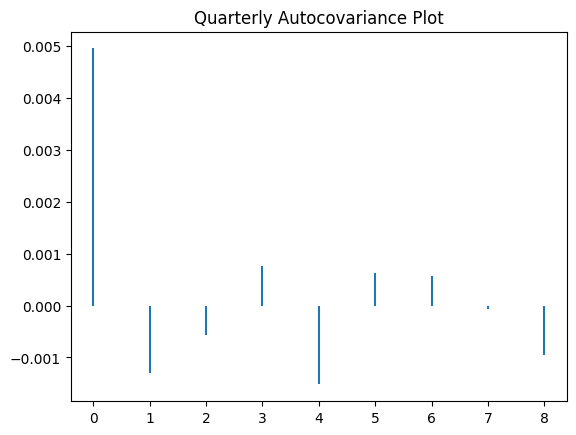

In [36]:
acf_plot(quarterly_resid, "Quarterly Autocorrelation Plot")
plot_acvf(quarterly_resid, "Quarterly Autocovariance Plot")